## Geometric Brownian Motion

The following is the equation for geometric brownian motion:

$$
\frac{\Delta S}{S} = \mu \Delta t + \sigma \epsilon \sqrt{\Delta t}
$$

Where:
$$
S = \text{the stock price}
$$
$$
\Delta S = \text{the change in stock price}
$$
$$
\mu = \text{the expected return} 
$$
$$
\sigma = \text{the standard deviation of returns}
$$
$$
\epsilon = \text{the random variable} 
$$
$$
\Delta t = \text{the elapsed time period}
$$
Re-aranging the equation we get:
$$
\Delta S = S \times (\mu \Delta t + \sigma \epsilon \sqrt{\Delta t})
$$
So we can model different trials by calculating $\Delta S$ at each time step, calculating the next price like the following:
$$
S_{t} = S_{t-1} + S_{t-1} \times (\mu \Delta t + \sigma \epsilon \sqrt{\Delta t})
$$
Simplifying:
$$
S_{t} = S_{t-1} (1 + (\mu \Delta t + \sigma \epsilon \sqrt{\Delta t}))
$$

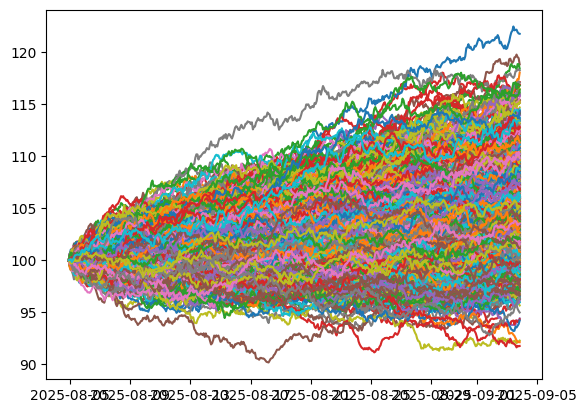

In [72]:
from tqdm.notebook import tqdm
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

mu = np.linspace(-0.5, 0.5, 2)
N_mu = len(mu)
N_sims = 1000
N_days = 30

start = dt.datetime.now()
end = start + dt.timedelta(days=N_days)
T = np.arange(start, end, np.timedelta64(1, '1m'))

S_0 = 100
epsilon = np.random.uniform(-1, 1, (N_sims, len(T)))
sigma = np.ones((N_sims, len(T))) * 0.075
delta_t = np.ones((N_sims, len(T))) * (1 / len(T))
mu = np.ones((N_sims, len(T))) * 0.05
S = S_0 * np.cumprod(1 + mu * delta_t + sigma * epsilon * np.sqrt(delta_t), axis=1)

for i in range(N_sims):
    time_stride = 100
    T_subset = T[::time_stride]
    S_subset = S[i, ::time_stride]
    plt.plot(T_subset, S_subset)
plt.show()

In [ ]:
# Create kernel for convolution
window = 1000
kernel = np.ones(window) / window

# Apply convolution to each row
result = np.apply_along_axis(
    lambda x: np.convolve(x, kernel, mode='valid'), 
    axis=1, 
    arr=S
)
S_means = np.full_like(S, np.nan)
S_means[:, window-1:] = result

# Fill the beginning with expanding means
for i in range(S.shape[0]):  # For each row
    for j in range(window-1):  # For each position before full window
        if j == 0:
            # First position: just the first value
            S_means[i, j] = S[i, j]
        else:
            # Other positions: mean of all available data points
            S_means[i, j] = np.mean(S[i, :j+1])
        
# Plot
for i in range(N_sims):
    time_stride = 100
    T_subset = T[::time_stride]
    S_means_subset = S_means[i, ::time_stride]
    plt.plot(T_subset, S_means_subset)
plt.show()

In [121]:
# Compute the buy and sell signals.
threshold = 0.001
S_signals = (np.abs(S - S_means) / S_means) > threshold
S_buys = S_signals & (S_means > S)
S_sells = S_signals & (S_means < S)

# Compute the cumulative actions.
S_actions = np.zeros_like(S)
S_actions[S_buys] = 1
S_actions[S_sells] = -1
S_actions = np.where(S_buys & S_sells, 0, S_actions)

# Only keep actions that do not repeat, excluding zeros.
def keep_non_repeating(x):
    non_zero_mask = np.where(x != 0)
    keep = np.take(non_zero_mask, np.where(np.diff(x[non_zero_mask], prepend=0) != 0)[0])
    keep_mask = np.zeros_like(x, dtype=bool)
    keep_mask[keep] = True
    return np.where(keep_mask, x, 0)
S_actions = np.apply_along_axis(keep_non_repeating, axis=1, arr=S_actions)

S_actions

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(1000, 43200))

In [125]:
np.cumprod(((np.where(S_actions == 1, 1, 0) * S) / (np.where(S_actions == -1, 1, 0) * S)), axis=1)

/var/folders/tc/qpkxsjrx4s72nqyhf67_1ctw0000gn/T/ipykernel_40580/3134698079.py:1: RuntimeWarning: divide by zero encountered in divide
  np.cumprod(((np.where(S_actions == 1, 1, 0) * S) / (np.where(S_actions == -1, 1, 0) * S)), axis=1)
/var/folders/tc/qpkxsjrx4s72nqyhf67_1ctw0000gn/T/ipykernel_40580/3134698079.py:1: RuntimeWarning: invalid value encountered in divide
  np.cumprod(((np.where(S_actions == 1, 1, 0) * S) / (np.where(S_actions == -1, 1, 0) * S)), axis=1)


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(1000, 43200))

In [ ]:
# Initialize the cash and positions.
initial_cash = 10000
S_positions = np.zeros(S.shape)
S_cash = np.full(S.shape, initial_cash)

In [99]:
S_cumulative_assets = np.cumsum(S_actions, axis=1)
S_cumulative_assets

array([[ 0.,  0.,  0., ..., -1., -1., -1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  1.,  1.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., -1., -1., -1.]], shape=(1000, 43200))

In [95]:
np.where(S_actions == 1, S, 0)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(1000, 43200))

In [ ]:
S_buys = np.where(S_actions == 1, 1, 0)
S_sells = np.where(S_actions == -1, 1, 0)


In [120]:
actions = np.array([0, 0, 1, 0, 0, -1, 0, 0, 0, 0, 1, 0, 0, 0])
prices = np.array([100, 101, 102, 103, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95])

positions = np.zeros_like(actions)
cash = np.zeros_like(actions)
initial_cash = 10000
cash[0] = initial_cash

for i in range(1, len(actions)):
    if actions[i] == 1:
        positions[i] = cash[i-1] / prices[i]
        cash[i] = 0
    elif actions[i] == -1:
        positions[i] = 0
        cash[i] = positions[i-1] * prices[i]
    else:
        positions[i] = positions[i-1]
        cash[i] = cash[i-1]

cumulative_assets = np.cumsum(actions)

initial_cash = 10000
cash[0] = initial_cash



display(pd.DataFrame({
    'actions': actions,
    'prices': prices,
    'positions': positions,
    'cumulative_assets': cumulative_assets,
    'cash': cash
}))

initial_cash * np.cumsum(actions) + np.cumsum(actions * prices)


,actions,prices,positions,cumulative_assets,cash
0,0,100,0,0,10000
1,0,101,0,0,10000
2,1,102,98,1,0
3,0,103,98,1,0
4,0,104,98,1,0
5,-1,103,0,0,10094
6,0,102,0,0,10094
7,0,101,0,0,10094
8,0,100,0,0,10094
9,0,99,0,0,10094


array([    0,     0, 10102, 10102, 10102,    -1,    -1,    -1,    -1,
          -1, 10097, 10097, 10097, 10097])

In [114]:
positions = np.zeros_like(actions)
cash = np.zeros_like(actions)
initial_cash = 10000
cash[0] = initial_cash

cumulative_assets = np.cumsum(actions)

display(pd.DataFrame({
    'actions': actions,
    'prices': prices,
    'positions': positions,
    'cumulative_assets': cumulative_assets,
    'cash': cash
}))

,actions,prices,positions,cumulative_assets,cash
0,0,100,0,0,10000
1,0,101,0,0,0
2,1,102,0,1,0
3,0,103,0,1,0
4,0,104,0,1,0
5,-1,103,0,0,0
6,0,102,0,0,0
7,0,101,0,0,0
8,0,100,0,0,0
9,0,99,0,0,0


In [105]:
103 * 95

9785

In [ ]:


for i in range(1, len(S)):
    if actions[i] == 1:
        positions[i] = cash[i-1] / prices[i]
        cash[i] = 0
    elif actions[i] == -1:

In [84]:
total_positions[-1]

np.float64(9998.0)

In [ ]:
positions[-1] * prices[-1]

np.int64(9785)

In [ ]:
# Solve using least squares
X = np.linspace(0, 1, len(T))
X_with_intercept = np.column_stack([np.ones(len(T)), X])
coefficients, residuals, rank, s = np.linalg.lstsq(X_with_intercept, S[0, :], rcond=None)

# Plot the data and the fitted line
plt.plot(T, S[0, :], label='Data')
plt.plot(T, coefficients[0] + coefficients[1] * X, label='Fitted line')
plt.legend()
plt.show()

In [ ]:
window_size = 1000
step_size = 1

S_means = np.zeros((len(T) - window_size + 1))

for i in range(0, len(T) - window_size + 1, step_size):
    X = np.linspace(0, 1, window_size)  
    X_with_intercept = np.column_stack([np.ones(window_size), X])
    coefficients_i, _, _, _ = np.linalg.lstsq(X_with_intercept, S[0, i:i+window_size], rcond=None)
    S_means[i] = coefficients_i[0] + coefficients_i[1]

plt.plot(T[window_size-1:], S[0, window_size-1:], label='Data')
plt.plot(T[window_size-1:], S_means, label='Predicted')
plt.legend()
plt.show()

In [ ]:
len(T) - window_size

In [ ]:
len(S[0, :len(T) - window_size + 1])

In [ ]:
len(S_means)

In [ ]:
((S - S_means) / S_means) > 0.001